# LV5 Model (VGG16 Transfer Learning)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
from keras.utils import to_categorical
import os
from keras.preprocessing.image import ImageDataGenerator, load_img

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
base_dir = './gdrive/My Drive/'
train_dir = os.path.join(base_dir, 'c5_train')
validation_dir = os.path.join(base_dir, 'c5_val')
test_dir = os.path.join(base_dir, 'c5_test')
heat_dir = os.path.join(base_dir, 'c5_heatmap')
model_dir = os.path.join(base_dir, 'model')

In [4]:
from keras.applications import VGG16

vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(299, 299, 3))

Instructions for updating:
Colocations handled automatically by placer.
58900480/58889256 [==============================] - 2s 0us/step


In [5]:
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0         
__________

In [0]:
nTrain = 576
nVal = 144
nTest = 63
nHeat = 900

In [7]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

train_features = np.zeros(shape=(nTrain, 9, 9, 512))
train_labels = np.zeros(shape=(nTrain,2))

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTrain:
        break
        
train_features = np.reshape(train_features, (nTrain, 9 * 9 * 512))

Found 576 images belonging to 2 classes.


In [8]:
validation_features = np.zeros(shape=(nVal, 9, 9, 512))
validation_labels = np.zeros(shape=(nVal,2))

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nVal:
        break

validation_features = np.reshape(validation_features, (nVal, 9 * 9 * 512))

Found 144 images belonging to 2 classes.


In [9]:
test_features = np.zeros(shape=(nTest, 9, 9, 512))
test_labels = np.zeros(shape=(nTest,2))

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

i = 0
for inputs_batch, labels_batch in test_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    test_features[i * batch_size : (i + 1) * batch_size] = features_batch
    test_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTest:
        break

test_features = np.reshape(test_features, (nTest, 9 * 9 * 512))

Found 63 images belonging to 2 classes.


## Neural Network model and training

In [10]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=9 * 9 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features,validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 576 samples, validate on 144 samples
Epoch 1/20
576/576 [==============================] - 12s 20ms/step - loss: 2.1820 - acc: 0.6458 - val_loss: 0.3294 - val_acc: 0.8472
Epoch 2/20
576/576 [==============================] - 11s 18ms/step - loss: 0.7387 - acc: 0.7569 - val_loss: 0.4332 - val_acc: 0.8056
Epoch 3/20
576/576 [==============================] - 11s 18ms/step - loss: 0.5825 - acc: 0.7847 - val_loss: 1.2945 - val_acc: 0.5139
Epoch 4/20
576/576 [==============================] - 11s 18ms/step - loss: 0.3351 - acc: 0.8628 - val_loss: 1.1067 - val_acc: 0.6806
Epoch 5/20
576/576 [==============================] - 11s 19ms/step - loss: 0.4366 - acc: 0.8229 - val_loss: 0.2642 - val_acc: 0.8958
Epoch 6/20
576/576 [==============================] - 11s 19ms/step - loss: 0.2468 - acc: 0.9062 - val_loss: 0.2070 - val

## Save Model

In [0]:
# Save the Model
model_name = 'lv5_vgg_c.h5'
model.save(os.path.join(model_dir, model_name))

In [0]:
# Recreate the exact same model, including weights and optimizer.
new_model = keras.models.load_model(os.path.join(model_dir, model_name))
#new_model.summary()

In [13]:
loss, acc = new_model.evaluate(validation_features,validation_labels)
print("Restored NN model, val accuracy: {:5.2f}%".format(100*acc))

loss, acc = new_model.evaluate(test_features,test_labels)
print("Restored NN model, test accuracy: {:5.2f}%".format(100*acc))

144/144 [==============================] - 0s 2ms/step
Restored NN model, val accuracy: 85.42%
63/63 [==============================] - 0s 2ms/step
Restored NN model, test accuracy: 95.24%


## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=0)
clf.fit(train_features, train_labels)
val_score = clf.score(validation_features, validation_labels)
test_score = clf.score(test_features, test_labels)
print("Random Forest, val accuracy: {:5.2f}%".format(100*val_score))
print("Random Forest, test accuracy: {:5.2f}%".format(100*test_score))

Random Forest, val accuracy: 93.06%
Random Forest, test accuracy: 100.00%


In [31]:
import pickle
# save the model to disk
forest_name = 'lv5_forest_c.sav'
pickle.dump(clf, open(os.path.join(model_dir, forest_name), 'wb'))

# load the model from disk
new_forest = pickle.load(open(os.path.join(model_dir, forest_name), 'rb'))
test_score = new_forest.score(test_features, test_labels)
print("Restored Random Forest, test accuracy: {:5.2f}%".format(100*test_score))

Restored Random Forest, test accuracy: 100.00%


In [122]:
from sklearn.metrics import classification_report, roc_auc_score
tree_pred = clf.predict(test_features)
print(classification_report(test_labels, tree_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        11

   micro avg       1.00      1.00      1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63
 samples avg       1.00      1.00      1.00        63



## Training Curve

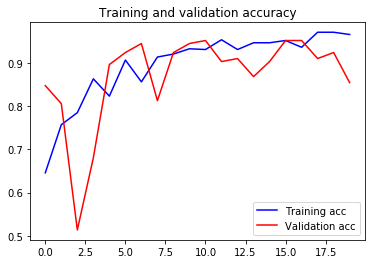

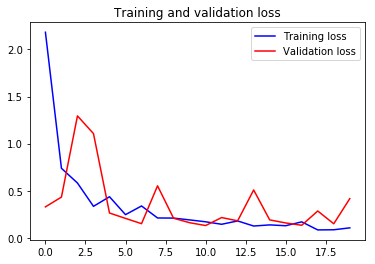

In [15]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Check Error-Causing Samples

In [0]:
fnames = test_generator.filenames

ground_truth = test_generator.classes

label2index = test_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.iteritems())

In [0]:
predictions = model.predict_classes(test_features)
prob = model.predict(test_features)

In [18]:
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nTest))

No of errors = 3/63


### Test images predicted wrongly

In [19]:
# Test set class ratio
neg_size = np.sum(test_labels[:,0])
pos_size = np.sum(test_labels[:,1])
print("Positive Class ritio %f" %(pos_size/nTest))
print("Negative Class ritio %f" %(neg_size/nTest))

Positive Class ritio 0.174603
Negative Class ritio 0.825397


Original label:0, Prediction :1, confidence : 0.570


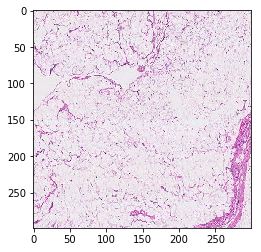

Original label:1, Prediction :0, confidence : 0.984


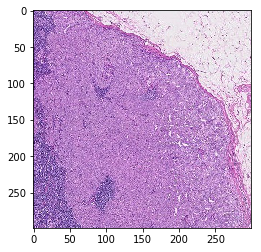

Original label:1, Prediction :0, confidence : 0.609


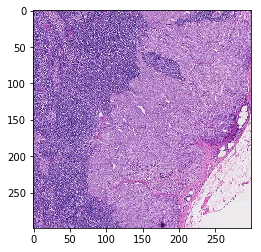

In [32]:
conf = []
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    conf.append(prob[errors[i]][pred_class])
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
    
    original = load_img('{}/{}'.format(test_dir,fnames[errors[i]]))
    plt.imshow(original)
    plt.show()

In [33]:
print("Average Mistake confidence: %f" %np.mean(conf))

Average Mistake confidence: 0.721198


## Evaluate Precision, Recall, F1, and AUROC

In [0]:
from sklearn.metrics import classification_report, roc_auc_score

In [0]:
# ont_hot to label
ground_truth = [0 if i[0]==1 else 1 for i in test_labels]

In [24]:
print(classification_report(ground_truth, predictions))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        52
           1       0.90      0.82      0.86        11

   micro avg       0.95      0.95      0.95        63
   macro avg       0.93      0.90      0.91        63
weighted avg       0.95      0.95      0.95        63



In [25]:
auc = roc_auc_score(ground_truth, prob[:,1])
print("AUROC: %f" %auc)

AUROC: 0.984266


## Generate Heatmap

In [58]:
! ls ./gdrive/My\ Drive/c5_heatmap/0 | wc -l
! ls ./gdrive/My\ Drive/c5_heatmap/1 | wc -l

166
734


In [59]:
heat_features = np.zeros(shape=(nHeat, 9, 9, 512))
heat_labels = np.zeros(shape=(nHeat,2))

heat_generator = datagen.flow_from_directory(
    heat_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

i = 0
for inputs_batch, labels_batch in heat_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    heat_features[i * batch_size : (i + 1) * batch_size] = features_batch
    heat_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nHeat:
        break

heat_features = np.reshape(heat_features, (nHeat, 9 * 9 * 512))

Found 900 images belonging to 2 classes.


### Neural Network Heatmap

In [0]:
predictions = model.predict_classes(heat_features)
prob = model.predict(heat_features)

In [0]:
heat = prob[:,1].reshape((30, 30))

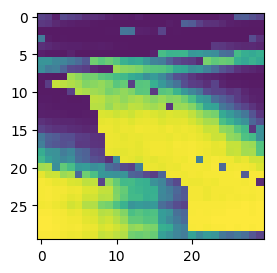

In [116]:
slide_patch = plt.imread(os.path.join(base_dir, 'heat/patch.jpg'))
mask_patch = plt.imread(os.path.join(base_dir, 'heat/mask.jpg'))
plt.figure(figsize=(3,3), dpi=100)
#plt.imshow(slide_patch)
plt.imshow(heat, cmap='viridis', alpha=0.9)
plt.savefig(os.path.join(base_dir, 'heat/heat_nn.png'))

In [169]:
nn_pred_heat = model.predict_classes(heat_features)
heat_gt = [0 if i[0]==1 else 1 for i in heat_labels]
print(classification_report(heat_gt, nn_pred_heat))

              precision    recall  f1-score   support

           0       0.40      1.00      0.57       166
           1       1.00      0.65      0.79       734

   micro avg       0.72      0.72      0.72       900
   macro avg       0.70      0.83      0.68       900
weighted avg       0.89      0.72      0.75       900



### Random Forest Heatmap

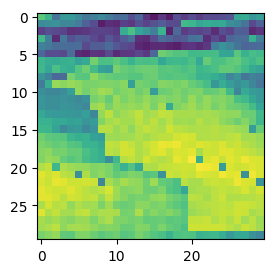

In [115]:
forest_pred = clf.predict_proba(heat_features)[0]
heat_forest = forest_pred[:,0].reshape((30, 30))
slide_patch = plt.imread(os.path.join(base_dir, 'heat/patch.jpg'))
mask_patch = plt.imread(os.path.join(base_dir, 'heat/mask.jpg'))
plt.figure(figsize=(3,3), dpi=100)
#plt.imshow(slide_patch)
plt.imshow(heat_forest, cmap='viridis', alpha=0.9)
plt.savefig(os.path.join(base_dir, 'heat/heat_forest.png'))

In [127]:
tree_pred_heat = clf.predict(heat_features)
print(classification_report(heat_labels, tree_pred_heat))

              precision    recall  f1-score   support

           0       1.00      0.27      0.43       166
           1       0.86      1.00      0.92       734

   micro avg       0.87      0.87      0.87       900
   macro avg       0.93      0.64      0.68       900
weighted avg       0.88      0.87      0.83       900
 samples avg       0.87      0.87      0.87       900



## Avg Heatmap

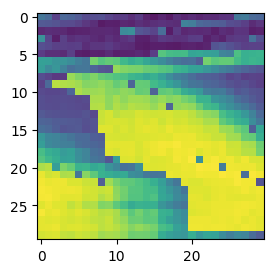

In [119]:
avg_heat = (heat_forest + heat)/2
slide_patch = plt.imread(os.path.join(base_dir, 'heat/patch.jpg'))
mask_patch = plt.imread(os.path.join(base_dir, 'heat/mask.jpg'))
plt.figure(figsize=(3,3), dpi=100)
#plt.imshow(slide_patch)
plt.imshow(avg_heat, cmap='viridis', alpha=0.9)
plt.savefig(os.path.join(base_dir, 'heat/heat_model_avg_lv5.png'))

In [152]:
avg_heat_label = [1 if i >= 0.35 else 0 for i in avg_heat.reshape(900,)] # thold 0.35, not 0.5
print(classification_report(heat_gt, avg_heat_label))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       166
           1       0.96      0.96      0.96       734

   micro avg       0.93      0.93      0.93       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.93      0.93      0.93       900



## Save heatmap prediction

In [0]:
# save prediction files
nn_test_proba = model.predict(test_features)[:,1]
rf_test_proba = clf.predict_proba(test_features)[0][:,1]
nn_heat_proba = model.predict(heat_features)[:,1]
rf_heat_proba = clf.predict_proba(heat_features)[0][:,1]
#print(nn_test_proba)
np.save(os.path.join(base_dir, 'heat/nn_test_lv5.npy'), nn_test_proba) # save nn test proba
np.save(os.path.join(base_dir, 'heat/rf_test_lv5.npy'), rf_test_proba) # save rf test proba
np.save(os.path.join(base_dir, 'heat/nn_heat_lv5.npy'), nn_heat_proba) # save nn heat proba
np.save(os.path.join(base_dir, 'heat/rf_heat_lv5.npy'), rf_heat_proba) # save rf heat proba

# test load
new_num_arr = np.load(os.path.join(base_dir, 'heat/rf_heat_lv5.npy')) # load
for i in range(len(new_num_arr)):
  assert new_num_arr[i] == rf_heat_proba [i]
  assert prob[i][1] == nn_heat_proba[i]

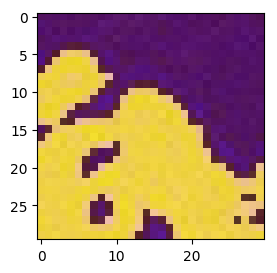

In [117]:
plt.figure(figsize=(3,3), dpi=100)
plt.imshow(slide_patch)
plt.imshow(mask_patch, cmap='viridis', alpha=0.8)